In [1]:
from studies.study_factory import StudyFactory
from dataloader.dataloader import DataLoader
from itertools import chain
import random
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import torch


dataloader = DataLoader(
    buffer_size=10,
    max_cache_size_gb=100,
    cache_dir="cache",
    notch_filter=True,
    frequency_bands={"all": (0.5, 100)},
    scaling="both",
    delay=0.15,
    brain_clipping=20,
    baseline_window=0.5,
    new_freq=200,
    batch_types={"audio": 2},
    batch_kwargs={
        "audio": {
            "max_random_shift": 1,
            "window_size": 30,
            "window_stride": 1,
            "audio_sample_rate": 16000,
            "hop_length": 160,
            "audio_processor": "openai/whisper-large-v3",
        }
    },
)

study = StudyFactory.create_study(
    study_name="gwilliams2023",
    batch_type="audio",
    path="data/gwilliams2023",
    cache_enabled=True,
    max_cache_size=200,  # in items
    cache_name="cache",
)


flat_recordings = list(chain.from_iterable(chain.from_iterable(study.recordings)))

2025-01-18 23:32:09,706	INFO worker.py:1821 -- Started a local Ray instance.


Loading Gwilliams2023 with batch type audio


In [2]:
import time

dataloader.start_fetching([flat_recordings[0]], cache=True)

# Process batches as they become available
try:
    batches, recs, start_time = 0, 0, time.time()
    print(f"Total recordings: {len(flat_recordings)}")

    while True:
        batch = dataloader.get_recording()

        if batch is None:
            break

        brain = batch.brain_segments["all"]
        batches += brain.shape[0]
        recs += 1

        if recs % 1 == 0:
            print(
                f"Batch {batches} ({recs} recordings) processed in {time.time() - start_time:.2f}s"
            )
            print(
                f"Average processing time per recording: {(time.time() - start_time) / recs:.2f}s"
            )
            print(
                f"Average processing time per batch: {(time.time() - start_time) / batches:.2f}s"
            )

        break

except KeyboardInterrupt:
    print("Interrupted")
    dataloader.stop()
except Exception as e:
    print("Error", e)
    dataloader.stop()

Total recordings: 196
Batch 134 (1 recordings) processed in 3.55s
Average processing time per recording: 3.55s
Average processing time per batch: 0.03s


Raw signal shape: torch.Size([1, 208, 6000])
Time taken: 0.05s
Shape of spectrogram: torch.Size([1, 208, 16, 3001])
Size of tensor: 0.04 GB
Estimated num batches per cpu: 175.22


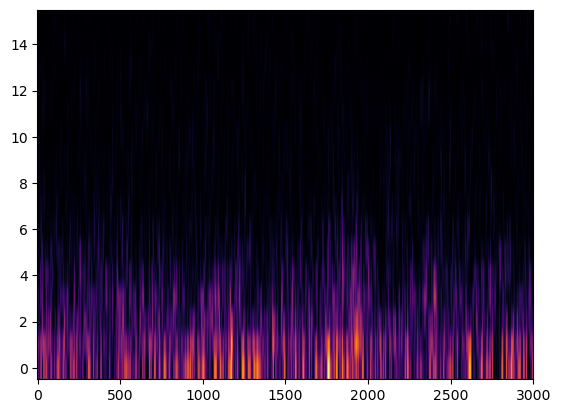

In [9]:
import time

device = "cpu"

raw = batch.brain_segments["all"][:1]
print(f"Raw signal shape: {raw.shape}")

n_fft = 32
bins = 16
t = raw.shape[-1]

spectrogram_transform = T.Spectrogram(
    n_fft=n_fft,
    hop_length=2,
    normalized=True,
    power=2,
).to(device)

start_time = time.time()
spec = torch.log1p(spectrogram_transform(raw.to(device)))
spec = spec[:, :, :bins, :t]
print(f"Time taken: {time.time() - start_time:.2f}s")
print(f"Shape of spectrogram: {spec.shape}")

plt.imshow(spec[0][0].numpy(), aspect="auto", origin="lower", cmap="inferno")
tensor_size = spec.numel() * spec.element_size() / 1e9
print(f"Size of tensor: {tensor_size:.2f} GB")
print(f"Estimated num batches per cpu: {7 / tensor_size:.2f}")

In [20]:
from config import SpectralConvConfig
from models.spectralconv import SpectralConv

model_config = SpectralConvConfig(
    # Str to list of possible conditions
    mel_normalization=False,
    conditions={
        "study": [],
        "subject": [],
    },
    # Channels
    in_channels=208,
    out_channels=128,
    hidden_dim=384,
    dropout=0.2,
    initial_group_norm=True,
    # Sensor layout settings
    layout_dim=2,
    layout_proj=True,
    layout_scaling="minmax",
    # Merger with spatial attn
    merger=True,
    merger_emb_type="fourier",
    merger_emb_dim=2048,
    merger_channels=256,
    merger_dropout=True,
    merger_conditional=None,
    # Inital
    initial_linear=384,
    initial_depth=1,
    # Conditional layers
    conditional_layers=False,
    conditional_layers_dim=None,  # input or hidden_dim
    # Conv layer overall structure
    cnn_channels=[384, 384, 384, 384, 384, 384],
    kernel_size=3,
    dilation_growth=2,
    dilation_period=5,
    glu=1,
    conv_dropout=0.2,
    dropout_input=0.2,
    group_norm=True,
    half=True,
    cnn_pos_encoding=True,
    bins=16,
    hop_length=2,
    # Quantizer
    quantizer=False,
    num_codebooks=0,
    codebook_size=0,
    quantizer_commitment=0,
    quantizer_temp_init=0,
    quantizer_temp_min=0,
    quantizer_temp_decay=0,
    # Transformers Encoders
    transformer_input=None,
    transformer_encoder_emb=None,
    transformer_encoder_layers=0,
    transformer_encoder_heads=0,
    # Transformer Decoders
    transformer_decoder_emb=None,
    transformer_decoder_layers=0,
    transformer_decoder_heads=0,
    transformer_decoder_dim=0,
)

model = SpectralConv(model_config).to("mps")

SpectralConv initialized with 99543441 parameters, cond: ['study', 'subject']
Merger True, merger channels 256
ConvBlocks: [384, 384, 384, 384, 384, 384], hidden_dim: 384, params 21833104


In [ ]:
recording = batch.recording

out = model(
    x=[raw],
    recording=[recording],
    conditions=[
        {
            "study": "gwilliams",
            "subject": f"{recording.study_name}_{recording.subject_id}",
        },
    ],
    mel=[],
    return_hidden_outputs=False,
)

NotImplementedError: The operator 'aten::_fft_r2c' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [7]:
# out[0].shape

torch.Size([1, 128, 3000])

In [46]:
# model_conv = SpectralConvSequence(
#     channels=[384, 384, 256, 128, 64, 32, 16, 8, 1],
#     kernel=3,
#     dilation_growth=2,
#     dilation_period=5,
#     stride=1,
#     dropout=0.2,
#     decode=False,
#     group_norm=True,
#     dropout_input=0.2,
#     glu=1,
#     activation=nn.GELU,
#     half=False,
#     pos_encoding=True,
#     mels=128,
# ).to("mps")

In [ ]:
# from models.simpleconv import SimpleConv
# from config import SimpleConvConfig

# model_config = SimpleConvConfig(
#     # Str to list of possible conditions
#     mel_normalization=False,
#     conditions={
#         "study": [],
#         "subject": [],
#     },
#     # Channels
#     in_channels=208,
#     out_channels=128,
#     hidden_dim=384,
#     dropout=0.2,
#     initial_batch_norm=True,
#     # Sensor layout settings
#     layout_dim=2,
#     layout_proj=True,
#     layout_scaling="minmax",
#     # Merger with spatial attn
#     merger=False,
#     merger_emb_type=None,
#     merger_emb_dim=0,
#     merger_channels=0,
#     merger_dropout=False,
#     merger_conditional=None,
#     # Inital
#     initial_linear=384,
#     initial_depth=1,
#     # Conditional layers
#     conditional_layers=False,
#     conditional_layers_dim=None,  # input or hidden_dim
#     # Conv layer overall structure
#     depth=6,
#     kernel_size=3,
#     growth=1.0,
#     dilation_growth=2,
#     dilation_period=5,
#     glu=1,
#     conv_dropout=0.2,
#     dropout_input=0.2,
#     batch_norm=True,
#     half=False,
#     cnn_pos_encoding=True,
#     # Quantizer
#     quantizer=False,
#     num_codebooks=0,
#     codebook_size=0,
#     quantizer_commitment=0,
#     quantizer_temp_init=0,
#     quantizer_temp_min=0,
#     quantizer_temp_decay=0,
#     # Transformers Encoders
#     transformer_input=None,
#     transformer_encoder_emb=None,
#     transformer_encoder_layers=0,
#     transformer_encoder_heads=0,
#     # Transformer Decoders
#     transformer_decoder_emb=None,
#     transformer_decoder_layers=0,
#     transformer_decoder_heads=0,
#     transformer_decoder_dim=0,
# )

# model_3 = SimpleConv(model_config)